# Numerical Solution of the Abel/Hayashi "q" investment model

## [Mateo Velásquez-Giraldo](https://github.com/Mv77)

In [1]:
# Preamble
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy import optimize

In [2]:
# Class implementation

class Qmod:
    """
    A class representing the Q investment model.
    """
    
    def __init__(self,beta,tau,alpha,omega,zeta,delta):
        """
        Inputs:
        - Beta:
        - Tau:
        - Alpha:
        - Omega:
        - Zeta:
        - Delta
        """
        # Assign parameter values
        self.beta = beta
        self.tau = tau
        self.alpha = alpha
        self.omega = omega
        self.zeta = zeta
        self.delta = delta
        
        # Create empty consumption function
        self.k1Func = None
        
        # Steady state capital
        self.kss = ((1-(1-self.delta)*self.beta)/((1-self.tau)*self.alpha))**(1/(self.alpha-1))
        
    def f_k(self,k):
        return(self.alpha*k**(self.alpha-1))
    
    def j(self,i,k):
        return(k/2*((i-self.delta*k)/k)**2*self.omega)
    
    def j_i(self,i,k):
        iota = i/k - self.delta
        return(iota*self.omega)
    
    def j_k(self,i,k):
        iota = i/k - self.delta
        return(-(iota**2/2+iota*self.delta)*self.omega)
    
    # Error in the euler equation implied by a k_0, k_1, k_2 triad.
    # This can be solved to obtain the adequate triads.
    def eulerError(self,k0,k1,k2):
        
        i0 = k1 - (1-self.delta)*k0
        i1 = k2 - (1-self.delta)*k1
        error = (1+self.j_i(i0,k0)) -\
        ((1-self.tau)*self.f_k(k1) +\
         ((1-self.delta) + (1-self.delta)*self.j_i(i1,k1) - self.j_k(i1,k1))*self.beta)
        
        return(error)
    
    # Find the k_2 implied by the euler equation for an initial k_0,
    # k_1.
    def k2(self,k0,k1):
        
        sol = optimize.root_scalar(lambda x: self.eulerError(k0,k1,x), x0=k0, x1=self.kss).root
        
        return(sol)
    
    # Find the capital trajectory implied by the euler equation for
    # an initial k_0, k_1.
    def shoot(self,k0,k1,t):
        k = np.zeros(t)
        k[0] = k0
        k[1] = k1
        for i in range(2,t):
            
            k[i] = self.k2(k[i-2],k[i-1])
            if k[i]<0 or (abs(k[i]-self.kss) > 2*abs(k0-self.kss)):
                k[i:] = k[i]
                return(k)
            
        return(k)
    
    # Shooting algorithm to find k_1 given k_0.
    def find_k1(self,k0,T=30,tol = 10**(-4),maxiter = 200):
            
        top = max(self.kss,k0)
        bot = min(self.kss,k0)
        
        for k in range(maxiter):
            
            init = (top+bot)/2
            path = self.shoot(k0,init,T)
    
            k_f = path[-1]
            if np.isnan(k_f):
                bot = init
            else:
                if abs(k_f - self.kss)<tol:
                    return(init)
                else:
                    if k_f >= self.kss:
                        top = init
                    else:
                        bot = init
            
        return(init)
    
    # Construction of the policy rule by solving for k_1 given
    # k_0 over a grid of points and then finding an interpolating
    # function
    def solve(self,k_min=10**(-3), n_points = 50):
        
        k_max = 4*self.kss
        k0 = np.linspace(k_min,k_max,n_points)
        k1 = np.zeros(len(k0))
        
        for i in range(len(k0)):
            
            k1[i] = self.find_k1(k0[i])
        
        self.k1Func = interpolate.interp1d(k0,k1)
    
    # Simulation of capital dynamics from a starting k_0
    def simulate(self,k0,t):
        k = np.zeros(t)
        k[0]=k0
        for i in range(1,t):
            k[i] = self.k1Func(k[i-1])
        return(k)

## _Examples_

In [3]:
# Create model object
Qexample = Qmod(beta = 0.99,tau = 0, alpha = 0.33, omega =  0.5, zeta =  0, delta = 0.05)
# Solve to find the policy rule (k[t+1] in terms of k[t])
Qexample.solve()

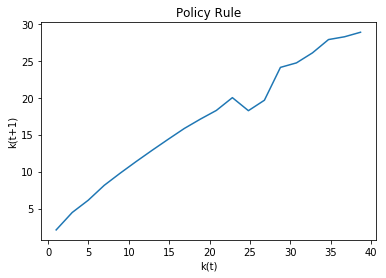

In [4]:
# Plot policy rule

k = np.linspace(1,3*Qexample.kss,20)

plt.plot(k,[Qexample.k1Func(x) for x in k])
plt.title('Policy Rule')
plt.xlabel('k(t)')
plt.ylabel('k(t+1)')
plt.show()

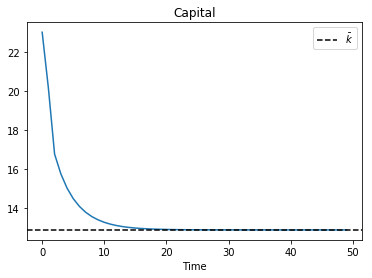

In [5]:
# Find capital dynamics from a given starting capital
k0 = 23
t = 50
k = Qexample.simulate(k0,t)

# Plot
plt.figure()
plt.plot(k)
plt.axhline(y = Qexample.kss,linestyle = '--',color = 'k', label = '$\\bar{k}$')
plt.title('Capital')
plt.xlabel('Time')
plt.legend()
plt.show()

### The impact of adjustment costs

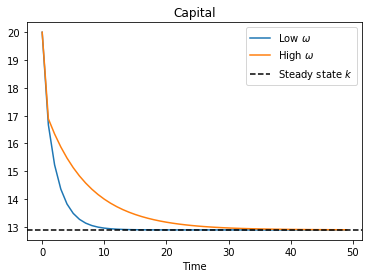

In [6]:
# Create and solve two instances, one with high and one with low adjustment costs omega
Qlow  = Qmod(beta = 0.99,tau = 0, alpha = 0.33, omega =  0.2, zeta =  0, delta = 0.05)
Qhigh = Qmod(beta = 0.99,tau = 0, alpha = 0.33, omega =  2.0, zeta =  0, delta = 0.05)

Qlow.solve()
Qhigh.solve()

# Simulate adjustment from an initial capital level
k0 = 20
t = 50
k_low = Qlow.simulate(k0,t)
k_high = Qhigh.simulate(k0,t)

# Plot
plt.figure()
plt.plot(k_low, label = 'Low $\\omega$')
plt.plot(k_high, label = 'High $\\omega$')
plt.axhline(y = Qexample.kss,linestyle = '--',color = 'k', label = 'Steady state ${k}$')
plt.title('Capital')
plt.xlabel('Time')
plt.legend()
plt.show()